# Espectrogramas

## Objetivos
Ao fim desta unidade, o aluno será capaz de **utilizar espectrogramas para análise de áudio**, configurando seus parâmetros de forma a evidenciar diferentes aspectos de um arquivo de áudio.

## Pré-requisitos
Neste ponto do curso, o aluno deve ter tranquilidade para interpretar as seguintes afirmações:

1. A *Transformada Discreta de Fourier* (TDF) converte um sinal discreto no domínio do tempo para sua representação no domínio da frequência;
1. Quanto maior é o intervalo de tempo (contínuo) sobre o qual calculamos uma transformada de Fourier, maior será sua resolução no domínio da frequência. Porém, a transformada de Fourier não permite identificar o instante, dentro desse intervalo de tempo, em que uma componente surge;

## Sinais não-estacionários
Hoje, conhecemos modelos importantes que determinam como um som estacionário se comporta ao longo do tempo. Por exemplo, sabemos que o conteúdo frequencial de uma corda vibrante está concentrado em regiões próximas aos seus modos de vibração, ou seja:
$$x(t) = \sum_{m=1}^M a_m \cos(2 \pi m f_0 t + \phi_m).$$

Note que esse modelo harmônico pode ser utilizado para analisar uma TDF.

Para as demonstrações a seguir, vamos considerar o caso de uma nota de piano gravada. Para acessar as amostras guardadas num arquivo .wav, podemos utilizar o seguinte código:

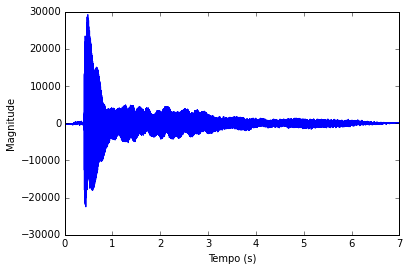

In [24]:
%matplotlib inline
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt
import IPython.lib.display as display 

fname = 'audio/piano.wav'
rate, data = scipy.io.wavfile.read(fname)
data = data.astype(np.float)
t = np.linspace(0, len(data)/rate, len(data))

plt.plot(t,data)
plt.ylabel('Magnitude')
plt.xlabel('Tempo (s)')
plt.show()

display.Audio(fname)

Sob um ponto de vista matemático, esse sinal não pode ser considerado estacionário, já que suas propriedades (como a magnitude) claramente variam ao longo do tempo. Em especial, é possível identificar que a nota *começa* próximo a $0.3$s e seu comportamento transiente (relacionado à percussão do martelo na corda) ocorre até próximo de $1$s.

Porém, sua TDF ainda nos fornece informações importantes, como vemos a seguir:

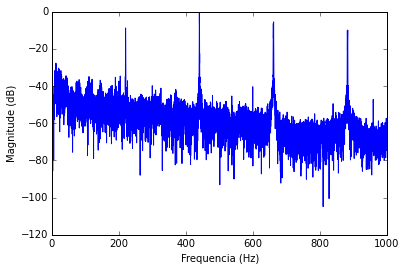

In [17]:
# Este codigo sobrepoe as variaveis definidas acima. Para voltar, sera preciso rodar tudo novamente.

# Processo da janela de Hanning
w = np.hanning(len(data))
dataw = data * w

yw = np.fft.fft(dataw) # A janela retangular eh definida implicitamente, neste caso.

freq = np.linspace(0, rate, len(yw))

fmax = 1000.
fmin = 000.

kmax = int(fmax * len(yw)/rate)
kmin = int(fmin * len(yw)/rate)

# Escala logaritmica no dominio da frequencia
yw = yw/np.max(np.abs(yw))
yw = 20 * np.log10(np.abs(yw)) # a magnitude sera expressa em dB, onde 0dB eh o maximo valor da magnitude


plt.plot(freq[kmin:kmax], yw[kmin:kmax])
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Magnitude (dB)')
plt.show()

Podemos verificar que quase todas as frequências estão presentes, mesmo que em baixa magnitude. Isso acontece porque um sinal gravado usualmente vem acompanhado de ruídos devidos ao ambiente, aos equipamentos ou mesmo ao próprio processo de amostragem e discretização.

Porém, mesmo assim, é possível encontrar componentes de frequência bastante fortes próximos a 220 HZ, 440 Hz, 660 Hz e 880 Hz. Essas frequências remetem, imediatamente, a uma Série de Fourier com $f_0 = 220$ Hz. Assim, a TDF permite identificar que a nota que soa neste arquivo de áudio é aquela que tem frequência fundamental de 220 Hz, ou seja, um lá na terceira oitava do piano.

## Análise em quadros

No exemplo acima, fizemos uma análise em duas etapas. Primeiro, identificamos os limites dentro dos quais poderíamos identificar uma nota musical. Depois, executamos o processo de identificação.

Neste processo, visualizamos os domínios do tempo e da frequência isoladamente. Isso pode levar à identificação errônea de alguns tipos de manifestações sonoras. Veja, por exemplo, o caso de um sinal que varia continuamente na magnitude e na frequência ao longo do tempo (ou seja: um *glissando*):

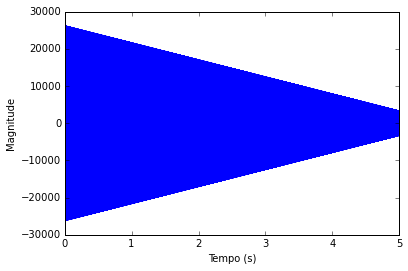

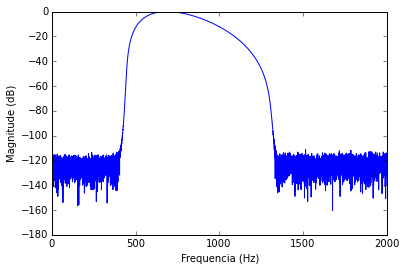

In [28]:
fname = 'audio/chirp.wav'
rate, data = scipy.io.wavfile.read(fname)
data = data.astype(np.float)
t = np.linspace(0, len(data)/rate, len(data))

plt.plot(t,data)
plt.ylabel('Magnitude')
plt.xlabel('Tempo (s)')
plt.show()

# Processo da janela de Hanning
w = np.hanning(len(data))
dataw = data * w

yw = np.fft.fft(dataw) # A janela retangular eh definida implicitamente, neste caso.

freq = np.linspace(0, rate, len(yw))

fmax = 2000.
fmin = 000.

kmax = int(fmax * len(yw)/rate)
kmin = int(fmin * len(yw)/rate)

# Escala logaritmica no dominio da frequencia
yw = yw/np.max(np.abs(yw))
yw = 20 * np.log10(np.abs(yw)) # a magnitude sera expressa em dB, onde 0dB eh o maximo valor da magnitude

plt.plot(freq[kmin:kmax], yw[kmin:kmax])
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Magnitude (dB)')
plt.show()

display.Audio(fname)

A informação auditiva deixa claro que trata-se de um glissando. Porém, ele não aparece claramente nem na representação no domínio do tempo nem no domínio da frequência. Para resolver esse problema, vamos propor a seguinte solução:

Dividiremos nosso sinal $x[n]$ em quadros $x_q[n]$ ($q \in \mathbb{N}$) de curta duração. Essa duração tem que ser curta o suficiente para que o fenômeno que observamos possa ser considerado estacionário (ou, ao menos, estacionário o bastante para permitir análise adequada). Também, tem que ser longa o bastante para garantir que a resolução no domínio da frequência seja suficiente para a análise que desejamos fazer.

O passo entre o início de dois quadros subsequentes também deve ser definido. Como temos utilizado uma janela de Hanning, é interessante que haja sobreposição de ao menos 50% das amostras de quadros. Do contrário, as amostras que ficam próximas às bordas do quadro serão desconsideradas, prejudicando a análise.

Tomaremos a TDF de cada um dos quadros. Desejamos mostrar somente seu módulo, portanto, descartaremos a fase. Isso nos dá uma matriz $\boldsymbol X \in \mathbb{R}^{K,Q}$, onde cada linha representa um coeficiente da TDF e cada coluna representa um quadro no tempo.

Esse procedimento já está implementado no pacote PyMIR3.

Porém, ainda será necessário mostrar essa informação na tela. Uma opção comum é utilizar cada ponto da matriz como um pixel de uma imagem. O processo de colorização da imagem (preto-no-branco, branco-no-preto, variações de coloração) depende do que deveria ser mostrado. Na literatura científica, é comum usar valores baixos como branco e valores altos como preto.

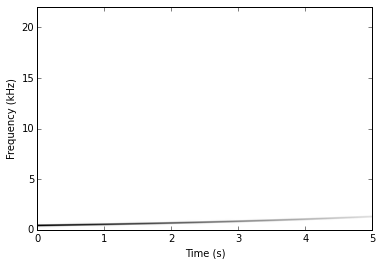

In [37]:
import mir3.modules.tool.wav2spectrogram as spec

fname = 'audio/chirp.wav'
c = spec.Wav2Spectrogram() # Objeto que converte arquivos wav para espectrogramas
s = c.convert(open(fname, 'rb'), window_length=512, window_step=256, spectrum_type='magnitude')

d = s.data                                                                   
d = d/numpy.max(d)                                                           
d = 1 - d                                                                    
                                                                                 
min_freq = s.metadata.min_freq                                               
max_freq = s.metadata.max_freq                                               
min_time = s.metadata.min_time                                               
max_time = s.metadata.max_time                                               
                                                                                
im = plt.imshow(d, aspect='auto', origin='lower', cmap=plt.cm.gray, extent=[min_time, max_time, min_freq/1000.0, max_freq/1000.0])       
plt.xlabel('Time (s)')                                                       
plt.ylabel('Frequency (kHz)')                                                
plt.show()                                                        

Verificamos que, ainda que esta figura nos dê alguma informação, pode ser útil remover toda a área branca acima da linha desenhada. O pacote PyMIR3 permite fazer isso usando o método trim() do espectrograma.

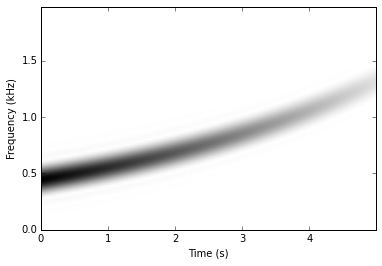

In [40]:
import mir3.modules.tool.trim_spectrogram as trim

tr = trim.TrimSpectrogram()
s = tr.trim(s, min_freq=0, max_freq=2000)

d = s.data                                                                   
d = d/numpy.max(d)                                                           
d = 1 - d                                                                    
                                                                                 
min_freq = s.metadata.min_freq                                               
max_freq = s.metadata.max_freq                                               
min_time = s.metadata.min_time                                               
max_time = s.metadata.max_time                                               
                                                                                
im = plt.imshow(d, aspect='auto', origin='lower', cmap=plt.cm.gray, extent=[min_time, max_time, min_freq/1000.0, max_freq/1000.0])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.show()

Esta figura mostra que:

1. Próximo a $t=0$s, há uma forte componente de frequência um pouco abaixo de 500 Hz;
1. Ao longo do tempo, a frequência dessa componente tende a subir, chegando até próximo de 1300 Hz;
1. A magnitude da componente cai, como fica evidenciado pelo clareamento da linha que a define (pontos mais escuros representam componentes de maior magnitude).

## Um caso real

Para mostrar outras possibilidades de um espectrograma, vamos tomar um novo exemplo: uma gravação de um guitarrista amador tocando frases baseadas em B. B. King.

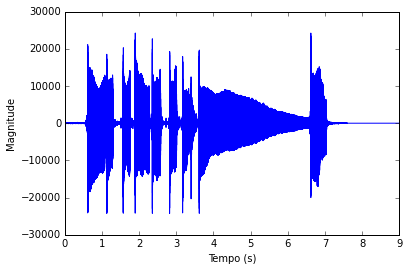

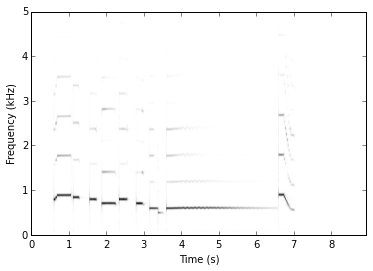

In [53]:
fname = 'audio/bbking.wav'
rate, data = scipy.io.wavfile.read(fname)
data = data.astype(np.float)
t = np.linspace(0, len(data)/rate, len(data))

plt.plot(t,data)
plt.ylabel('Magnitude')
plt.xlabel('Tempo (s)')
plt.show()

c = spec.Wav2Spectrogram() # Objeto que converte arquivos wav para espectrogramas
s = c.convert(open(fname, 'rb'), window_length=2048, window_step=1024, spectrum_type='magnitude')
tr = trim.TrimSpectrogram()
s = tr.trim(s, min_freq=0, max_freq=5000)

d = s.data                                                                   
d = d/numpy.max(d)                                                           
d = 1 - d                                                                    
                                                                                 
min_freq = s.metadata.min_freq                                               
max_freq = s.metadata.max_freq                                               
min_time = s.metadata.min_time                                               
max_time = s.metadata.max_time                                               
                                                                                
im = plt.imshow(d, aspect='auto', origin='lower', cmap=plt.cm.gray, extent=[min_time, max_time, min_freq/1000.0, max_freq/1000.0])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.show()

display.Audio(fname)

Podemos verificar as raias espectrais correspondentes às notas musicais. Elas indicam os componentes da Série de Fourier que é a solução do movimento de vibração das cordas.

Também, o espectrograma permite verificar que a frequência fundamental da nota longa, que começa perto de $3$s, oscila rapidamente ao longo do tempo, indicando um *vibrato*. Por fim, os tons de cinza fornecem uma visualização das magnitudes relativas entre os picos, mostrando que a magnitude da frequência fundamental, neste caso, é superior aos demais.

Porém, essa mesma visualização pode enganar os olhos. É possível que componentes mais fracas tenham ficado muito apagadas para serem visíveis. Uma possível solução para isso é aplicar uma escala logaritmica ao módulo da TDF antes de mostrá-la:

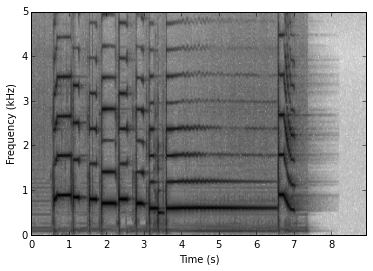

In [56]:
s = c.convert(open(fname, 'rb'), window_length=2048, window_step=1024, spectrum_type='log')
tr = trim.TrimSpectrogram()
s = tr.trim(s, min_freq=0, max_freq=5000)

d = s.data                                                                   
d = d/numpy.max(d)                                                           
d = 1 - d                                                                    
                                                                                 
min_freq = s.metadata.min_freq                                               
max_freq = s.metadata.max_freq                                               
min_time = s.metadata.min_time                                               
max_time = s.metadata.max_time                                               
                                                                                
im = plt.imshow(d, aspect='auto', origin='lower', cmap=plt.cm.gray, extent=[min_time, max_time, min_freq/1000.0, max_freq/1000.0])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.show()

display.Audio(fname)

Essa nova visualização mostra mais componentes de frequência que a anterior. Porém, ao mesmo tempo, ela mostra muito mais ruído. De fato, não há uma solução "perfeita" para a questão da visualização de espectrogramas - será sempre necessário fazer um compromisso entre a quantidade de informação mostrada e a quantidade de ruído aceitável. Tudo dependerá de *o que* deseja-se mostrar.

## Sons não-harmônicos
Como pudemos ver, a TDF é uma ótima ferramenta de visualização para sons harmônicos. Vejamos o que acontece com o espectrograma de uma sequência de percussões:


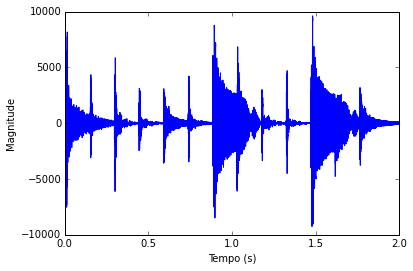

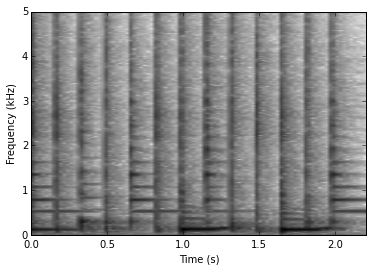

In [58]:
fname = 'audio/tabla.wav'
rate, data = scipy.io.wavfile.read(fname)
data = data.astype(np.float)
t = np.linspace(0, len(data)/rate, len(data))

plt.plot(t,data)
plt.ylabel('Magnitude')
plt.xlabel('Tempo (s)')
plt.show()

c = spec.Wav2Spectrogram() # Objeto que converte arquivos wav para espectrogramas
s = c.convert(open(fname, 'rb'), window_length=2048, window_step=1024, spectrum_type='log')
tr = trim.TrimSpectrogram()
s = tr.trim(s, min_freq=0, max_freq=5000)

d = s.data                                                                   
d = d/numpy.max(d)                                                           
d = 1 - d                                                                    
                                                                                 
min_freq = s.metadata.min_freq                                               
max_freq = s.metadata.max_freq                                               
min_time = s.metadata.min_time                                               
max_time = s.metadata.max_time                                               
                                                                                
im = plt.imshow(d, aspect='auto', origin='lower', cmap=plt.cm.gray, extent=[min_time, max_time, min_freq/1000.0, max_freq/1000.0])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.show()

display.Audio(fname)

Ao ouvirmos o som, podemos distinguir claramente ao menos dois sons diferentes. Porém, essa diferença não fica completamente clara no espectrograma. As linhas verticais se relacionam a sons percussivos, e é difícil distingui-los usando somente a inspeção visual. Essas mesmas linhas estão presentes no som de guitarra, e se relacionam ao toque da palheta na corda (que também é um som percussivo).

Elas aparecem porque cossenóides são modelos pouco informativos em relação a sinais impulsivos. Assim, se um sinal é semelhante a um impulso, são necessárias muitas cossenóides diferentes para explicá-lo. Uma maneira mais "matemática" de explicar o mesmo fenômeno é calculando a Transformada de Fourier de uma função impulsiva, modelada por um delta de dirac:
$$\int _{-\infty}^{\infty} \delta(t) e^{-2 \pi f j t} dt$$

Esse cálculo mostra que a Transformada de Fourier de um sinal impulsivo é constante em todo o espectro de frequências, e, portanto, será representado por uma linha vertical em um espectrograma.

# Exercícios

1. Baixe amostras de violinos, saxfones e flautas de um ou mais repositórios livres na Internet tal como o Iowa University Musica Instrument Samples (http://theremin.music.uiowa.edu/). Tomando por base seus espectrogramas, comente as diferenças sonoras entre eles. Lembre-se que, provavelmente, as amostras terão que ser pré-processadas para que possam ser lidas pelo Python em formato .wav, mono, 16 bits por amostra e representação inteira sem sinal.
1. Tomando por base os mesmos espectrogramas, tente encontrar características do espectro que permitam diferenciar violinos, saxofones e flautas.
1. Discuta com um colega as características que voces encontraram. Tente entender como foi o raciocínio do colega para chegar a essas características.
1. Escolham, juntos, ao menos duas delas, e tente escrevê-la na forma de uma expressão que pode ser calculada à partir do espectrograma, representado pela matriz $\boldsymbol X$ tal que $x_{k,q}$ representa o $k$-ésimo coeficiente da TDF no quadro $q$.